In [33]:
# LOAD PACKAGES

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from numpy import asarray
import rioxarray as rxr
import rasterio
import geopandas as gpd
import xarray as xr
import pandas as pd
import glob
import seaborn as sns
import os
import fnmatch
import math
from math import e
from osgeo import gdal 
print("packages loaded")

packages loaded


In [34]:
def ppp_av(dnbr, 
          plot=False, 
          save=False):
    
    # Coefficients for Southern California
    b = -3.63
    b_1 = 0.41
    b2 = 0.67
    b_2 = np.array(b2)
    b_3 = 0.7
    
    
    dnbr_flat = dnbr.values.flatten()
    pixarr = np.empty((dnbr_flat.shape[0]), dtype= float)
    pixarr[:] = np.nan
    x = np.where(np.isnan(dnbr_flat) == False)
        
    # Getting the data from dnbr_flat
    dnbrdata = dnbr_flat[x]
    print(f'dnbrdata: {dnbrdata}')   
    # Matching index of x_values_df[basin_id] to shapefile
    individual_basin = x_values_df.index[x_values_df['basin_id'] == int(basin)]
        
    # Pulling individual values from x_1 and x_3, creating pixel values for x_2 denoted by s & s1
    x_1 = x_values_df['x1'][individual_basin]
    x_3 = x_values_df['x3'][individual_basin]
    s = np.multiply(dnbrdata, b_2)
    s1 = np.multiply(s, val)
    # s1 multiplication assumes when function is called that val is defined globally in code.
    
    # Per pixel analysis, probability stored in empty list p1
    p1 = []
    for i in s1:
        lnx =  b + (b_1 * x_1 * val) + i + (b_3 * x_3 * val)
        prob = (e ** lnx) / (1.0 + e ** lnx)
        p1.append(prob)
       
    # Append probability array, flatten data, reshape into image
    prob_arr = np.array(p1)
    p_final = prob_arr.flatten()
    pixarr[x] = p_final
    print(f'pixarr: {pixarr}')
    print(f'dnbr shape: {dnbr.shape}')
    pixarrImg = pixarr.reshape((dnbr.shape[1], dnbr.shape[2]))
    out_dnbr = xr.Dataset()
    out_dnbr = xr.DataArray(pixarrImg, dims = ('y', 'x'),
                            coords = {'x': dnbr.coords['x'],
                                      'y': dnbr.coords['y']})
    
    if plot == True:
        out_dnbr.plot(
            cmap = 'gnuplot',
            vmax = 1,
            vmin = 0)
        plt.title(f"Basin {basin} Per Pixel Initiation Probablilty, R = {int(val*4)}mm/hr")
    
    if save == True:
        outname = f"{basin}_ppp_{int(val*4)}mmhr.tif"
        out_dnbr.rio.to_raster(os.path.join(ppp_out, outname), driver='GTIFF')
        print(f"Basin {basin} {int(val*4)}mm/hr per pixel analysis saved as geotiff")
        
        print(f"Basin {basin} {int(val*4)}mm/hr per pixel analysis complete")
    return out_dnbr

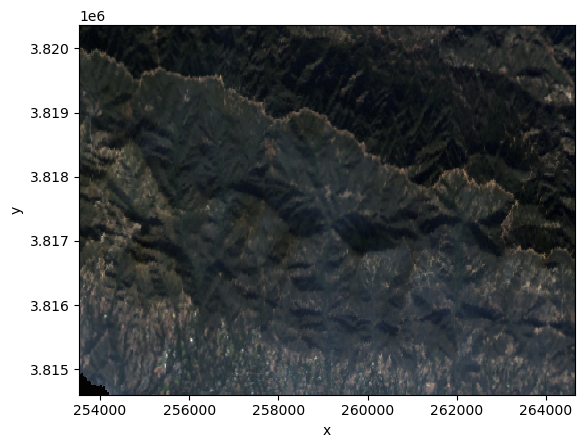

In [35]:
post_h = '/mnt/nfs/lss/meerdink/home/skzebarth/masters/AVIRIS/pre_fire/171206/171206_av_20m_final_clip'
def normalize(array):
        """Normalizes numpy arrays into scale 0.0 - 1.0"""
        array_min, array_max = array.min(), array.max()
        return ((array - array_min)/(array_max - array_min))
image = rxr.open_rasterio(post_h)
#print(image)
red1 = image.data[28,:,:]
green1 = image.data[19,:,:]
blue1 = image.data[11,:,:]
red = normalize(red1)
green = normalize(green1)
blue = normalize(blue1)
dataPlot = np.zeros((red.shape[0],red.shape[1],3))
dataPlot[:,:,0] = red
dataPlot[:,:,1] = green
dataPlot[:,:,2] = blue

img = xr.Dataset()
img = xr.DataArray(dataPlot,
                        dims = ('y', 'x', 'band'),
                        coords ={'y': image.coords['y'], 
                                    'x': image.coords['x'],
                                    'band': ["red", "green", "blue"]})
img.plot.imshow()
#flat = (image.data).to_numpy().reshape(np.shape(image.data)[0],-1)

<xarray.DataArray (y: 172, x: 116)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x            (x) float64 2.541e+05 2.541e+05 ... 2.564e+05 2.564e+05
  * y            (y) float64 3.82e+06 3.82e+06 3.82e+06 ... 3.816e+06 3.816e+06
    spatial_ref  int64 0


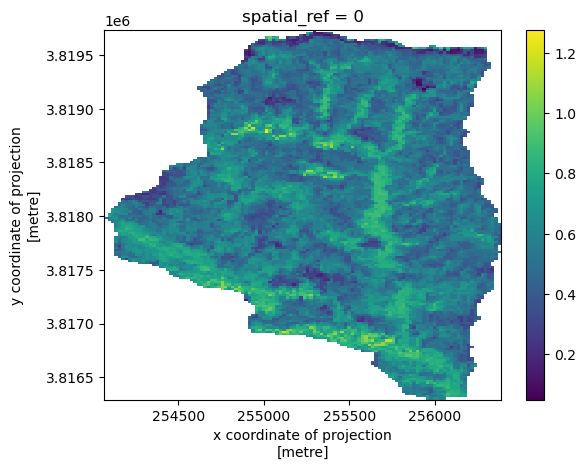

In [36]:
pre_h = '/mnt/nfs/lss/meerdink/home/skzebarth/masters/AVIRIS/move/final_envi/171206_av_area_final_clip'

dirPolyLoc = '/mnt/nfs/lss/meerdink/home/skzebarth/masters/shapefiles/17346.shp'

shape = gpd.read_file(dirPolyLoc)

image = rxr.open_rasterio(pre_h, masked=True)

#print(image)
nir = image[62,:,:]
swir = image[217,:,:]



def nbr_clip(nir, swir, 
             shape, 
             plot=False, 
             save=False):
    basin_NIR = nir.rio.clip(shape.geometry.values,
                                shape.crs,
                                all_touched = False,
                                drop = True,
                                invert = False)
    
    basin_SWIR = swir.rio.clip(shape.geometry.values,
                                shape.crs,
                                all_touched = False,
                                drop = True,
                                invert = False)
    
    nbr = (basin_NIR - basin_SWIR) / (basin_NIR + basin_SWIR)
    
    return nbr

x = nbr_clip(nir, swir, shape)
print(x)
x.plot()


float32
<xarray.DataArray (y: 172, x: 116)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x            (x) float64 2.541e+05 2.541e+05 ... 2.564e+05 2.564e+05
  * y            (y) float64 3.82e+06 3.82e+06 3.82e+06 ... 3.816e+06 3.816e+06
    spatial_ref  int64 0


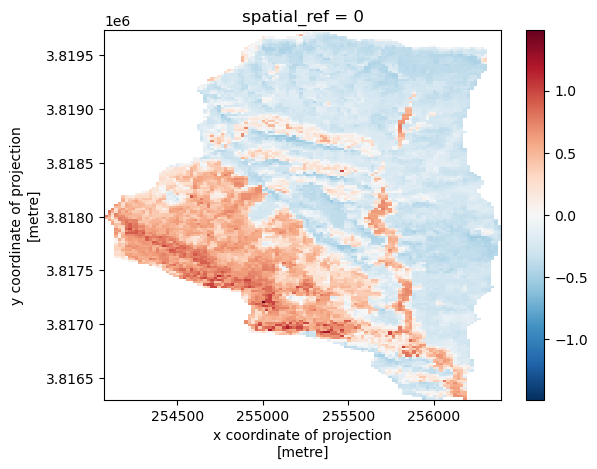

In [37]:
post_h = '/mnt/nfs/lss/meerdink/home/skzebarth/masters/AVIRIS/move/final_envi/171221_av_area_final'
image2 = rxr.open_rasterio(post_h, masked=True)
b63a = image2[63,:,:]
b218a = image2[218,:,:]
print(image2.data.dtype)
y = nbr_clip(b63a, b218a, shape)
print(y)
y.plot()

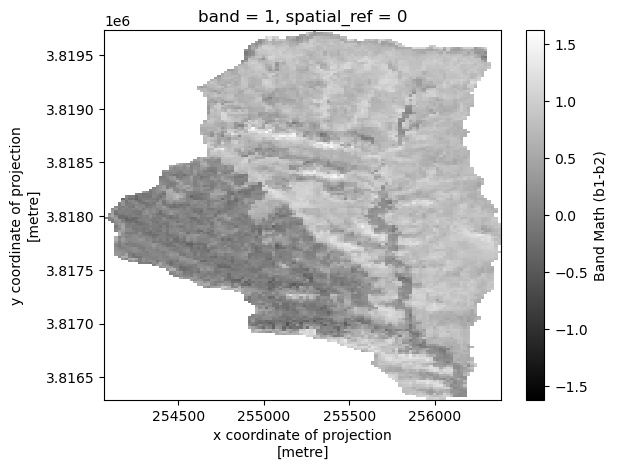

In [38]:
dnbr = rxr.open_rasterio('/mnt/nfs/lss/meerdink/home/skzebarth/masters/AVIRIS/move/final_envi/dnbr_aviris')
dnbr_clip = dnbr.rio.clip(shape.geometry.values,
                                shape.crs,
                                all_touched = False,
                                drop = True,
                                invert = False)
dnbr_clip.plot(cmap = 'gray')


dnbrdata: [0.32927656 0.93155205 0.6421544  ... 1.048065   0.9373443  0.9401189 ]
pixarr: [nan nan nan ... nan nan nan]
dnbr shape: (1, 172, 116)


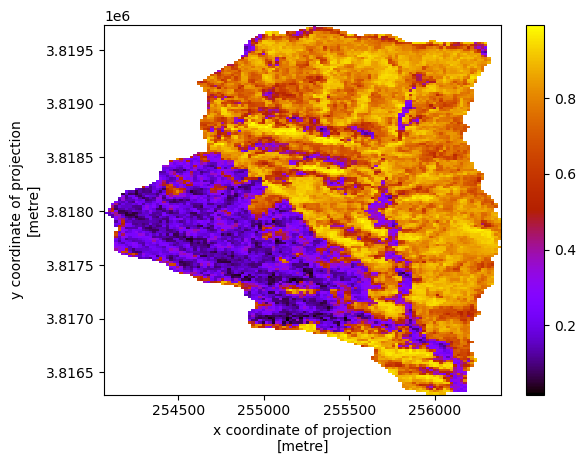

In [41]:
x_values_df = pd.read_csv('/mnt/nfs/lss/meerdink/home/skzebarth/masters/basin_data/ma_data.csv', 
                          delimiter=',')
basin = '17346'
R = [6.0]
for val in R:
    ppp_img = ppp(dnbr_clip)
    ppp_img.plot(cmap='gnuplot')